## 8.2.1

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import scipy.spatial
import functools

%matplotlib inline

In [2]:
### Kernel function generators
def linear_kernel(W, X):
    """
    Computes the linear kernel between two sets of vectors.
    Args:
        W, X - two matrices of dimensions n1xd and n2xd
    Returns:
        matrix of size n1xn2, with w_i^T x_j in position i,j
    """
    return np.dot(W,np.transpose(X))
 
def RBF_kernel(W,X,sigma):
    """
    Computes the RBF kernel between two sets of vectors   
    Args:
        W, X - two matrices of dimensions n1xd and n2xd
        sigma - the bandwidth (i.e. standard deviation) for the RBF/Gaussian kernel
    Returns:
        matrix of size n1xn2, with exp(-||w_i-x_j||^2/(2 sigma^2)) in position i,j
    """
    kernel = scipy.spatial.distance.cdist(W,X,'sqeuclidean')
    kernel = (-kernel)/(2*(sigma**2))
    return np.exp(kernel)
    
    
    

def polynomial_kernel(W, X, offset, degree):
    """
    Computes the inhomogeneous polynomial kernel between two sets of vectors
    Args:
        W, X - two matrices of dimensions n1xd and n2xd
        offset, degree - two parameters for the kernel
    Returns:
        matrix of size n1xn2, with (offset + <w_i,x_j>)^degree in position i,j
    """
    kernel = np.dot(W,np.transpose(X))
    kernel = offset + kernel 
    
    return (kernel)**degree


## 8.2.2

In [3]:
x0 = np.array([[-4],[-1],[0],[2]])
linear_kernel(x0,x0)

array([[16,  4,  0, -8],
       [ 4,  1,  0, -2],
       [ 0,  0,  0,  0],
       [-8, -2,  0,  4]])

## 8.2.3

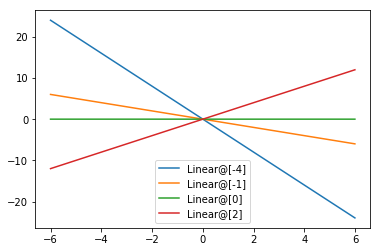

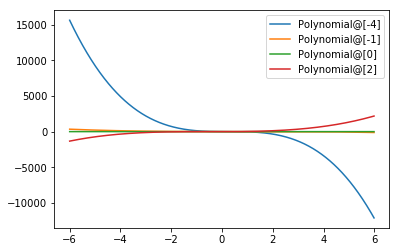

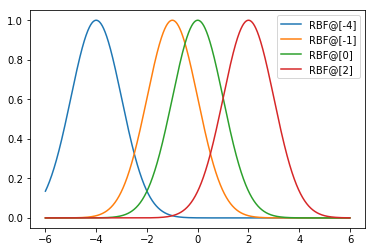

In [4]:
# PLot kernel machine functions

plot_step = .01
xpts = np.arange(-6.0, 6, plot_step).reshape(-1,1)
prototypes = np.array([-4,-1,0,2]).reshape(-1,1)

# Linear kernel
y = linear_kernel(prototypes, xpts) 
for i in range(len(prototypes)):
    label = "Linear@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show() 

#Polynomial
y = polynomial_kernel(prototypes, xpts,1,3) 
for i in range(len(prototypes)):
    label = "Polynomial@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show() 
 
#RBF
y = RBF_kernel(prototypes, xpts,1) 
for i in range(len(prototypes)):
    label = "RBF@"+str(prototypes[i,:])
    plt.plot(xpts, y[i,:], label=label)
plt.legend(loc = 'best')
plt.show()
 

## 8.2.4

In [5]:
class Kernel_Machine(object):
    def __init__(self, kernel, prototype_points, weights):
        """
        Args:
            kernel(W,X) - a function return the cross-kernel matrix between rows of W and rows of X for kernel k
            prototype_points - an Rxd matrix with rows mu_1,...,mu_R
            weights - a vector of length R
        """

        self.kernel = kernel
        self.prototype_points = prototype_points
        self.weights = weights
        
    def predict(self, X):
        """
        Evaluates the kernel machine on the points given by the rows of X
        Args:
            X - an nxd matrix with inputs x_1,...,x_n in the rows
        Returns:
            Vector of kernel machine evaluations on the n points in X.  Specifically, jth entry of return vector is
                Sum_{i=1}^R w_i k(x_j, mu_i)
        """
         
        self.kernlized_points = self.kernel(self.prototype_points,X)
        return  np.dot(self.kernlized_points.T,self.weights) 
            
        
        

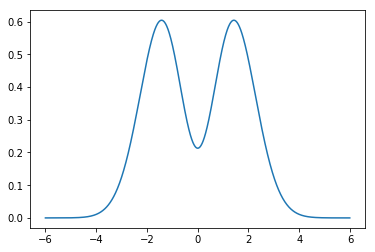

In [6]:
prototypes = np.array([[-1],[0],[1]])
weight = np.array([[1],[-1],[1]])

k = functools.partial(RBF_kernel, sigma = 1)
y = Kernel_Machine(k, prototypes, weight).predict(xpts)
plt.plot(xpts, y)

## 8.3.1
Load train & test data; Convert to column vectors so it generalizes well to data in higher dimensions.

In [7]:
data_train,data_test = np.loadtxt("krr-train.txt"),np.loadtxt("krr-test.txt")
x_train, y_train = data_train[:,0].reshape(-1,1),data_train[:,1].reshape(-1,1)
x_test, y_test = data_test[:,0].reshape(-1,1),data_test[:,1].reshape(-1,1)

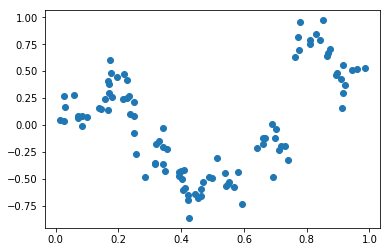

In [8]:
plt.plot(x_train, y_train,"o")

## 8.3.2

In [9]:
def train_kernel_ridge_regression(X, y, kernel, l2reg):
    alpha = np.dot(np.linalg.inv((l2reg*np.identity(X.shape[0])+kernel(X,X))),y)
    
    return Kernel_Machine(kernel, X, alpha)

## 8.3.3

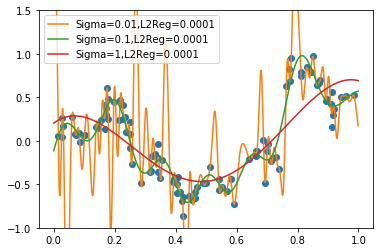

In [10]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
l2reg = 0.0001
for sigma in [.01,.1,1]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

#### It seems that when sigma equals to 1 is much more generalized. When sigma is smaller, it looks much more likely to overfit

## 8.3.4

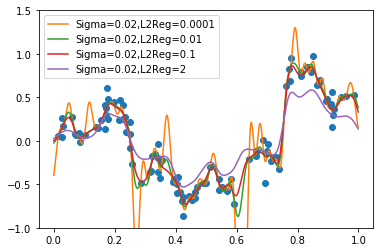

In [11]:
plot_step = .001
xpts = np.arange(0 , 1, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
sigma= .02
for l2reg in [.0001,.01,.1,2]:
    k = functools.partial(RBF_kernel, sigma=sigma)
    f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
    label = "Sigma="+str(sigma)+",L2Reg="+str(l2reg)
    plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.5)
plt.show()

#### When lambda is 0.0001, the line looks very close to data points. I think when lambda is getting close to inifity, it will be an almost straight line that is over-generalized.

## 8.3.5

In [12]:
from sklearn.base import BaseEstimator, RegressorMixin, ClassifierMixin

class KernelRidgeRegression(BaseEstimator, RegressorMixin):  
    """sklearn wrapper for our kernel ridge regression"""
     
    def __init__(self, kernel="RBF", sigma=1, degree=2, offset=1, l2reg=1):        
        self.kernel = kernel
        self.sigma = sigma
        self.degree = degree
        self.offset = offset
        self.l2reg = l2reg 

    def fit(self, X, y=None):
        """
        This should fit classifier. All the "work" should be done here.
        """
        if (self.kernel == "linear"):
            self.k = linear_kernel
        elif (self.kernel == "RBF"):
            self.k = functools.partial(RBF_kernel, sigma=self.sigma)
        elif (self.kernel == "polynomial"):
            self.k = functools.partial(polynomial_kernel, offset=self.offset, degree=self.degree)
        else:
            raise ValueError('Unrecognized kernel type requested.')
        
        self.kernel_machine_ = train_kernel_ridge_regression(X, y, self.k, self.l2reg)

        return self

    def predict(self, X, y=None):
        try:
            getattr(self, "kernel_machine_")
        except AttributeError:
            raise RuntimeError("You must train classifer before predicting data!")

        return(self.kernel_machine_.predict(X))

    def score(self, X, y=None):
        # get the average square error
        return((self.predict(X)-y).mean()) 

In [18]:
from sklearn.model_selection import GridSearchCV,PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error,make_scorer
import pandas as pd
    
test_fold = [-1]*len(x_train) + [0]*len(x_test)   #0 corresponds to test, -1 to train
predefined_split = PredefinedSplit(test_fold=test_fold)

In [51]:
param_grid = [{'kernel': ['RBF'],'sigma':np.logspace(-10, 2, 100), 'l2reg': np.logspace(-5, 5, 100)},
              {'kernel':['polynomial'],'offset':np.linspace(-5, 5, 100), 'degree':np.arange(2,15,1),'l2reg':np.logspace(-10, 2, 100) },
              {'kernel':['linear'],'l2reg': np.logspace(-5, 5, 100)}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False)
                  # n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test))) 



pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])


#find the best
best_linear = df_toshow.ix[df_toshow[df_toshow.param_kernel == "linear"]["mean_test_score"].argmin()]
best_rbf = df_toshow.ix[df_toshow[df_toshow.param_kernel == "RBF"]["mean_test_score"].argmin()]
best_polynomial = df_toshow.ix[df_toshow[df_toshow.param_kernel == "polynomial"]["mean_test_score"].argmin()]

pd.concat([best_linear, best_rbf, best_polynomial], axis=1).T

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
140055,-,linear,3.59381,-,-,0.16451,0.206552
4472,-,RBF,0.278256,-,0.053367,0.0138428,0.0141175
120043,13,polynomial,1e-10,-0.656566,-,0.0216871,0.0254216


#### Narrowing down to a smaller range

In [58]:
param_grid = [{'kernel': ['RBF'],'sigma':np.logspace(-2, -1, 100), 'l2reg': np.logspace(-1,0, 100)},
              {'kernel':['polynomial'],'offset':np.linspace(-0.8, -.5, 100), 'degree':np.arange(12,14,1),'l2reg':np.logspace(-11, -9, 100) },
              {'kernel':['linear'],'l2reg': np.logspace(0, 1, 100)}]


kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False)
                  # n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test)))


pd.set_option('display.max_rows', 20)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])



best_linear = df_toshow.ix[df_toshow[df_toshow.param_kernel == "linear"]["mean_test_score"].argmin()]
best_rbf = df_toshow.ix[df_toshow[df_toshow.param_kernel == "RBF"]["mean_test_score"].argmin()]
best_polynomial = df_toshow.ix[df_toshow[df_toshow.param_kernel == "polynomial"]["mean_test_score"].argmin()]

pd.concat([best_linear, best_rbf, best_polynomial], axis=1).T




,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
30059,-,linear,3.94421,-,-,0.16451,0.206561
2477,-,RBF,0.174753,-,0.0599484,0.0138052,0.014419
25450,13,polynomial,1.23285e-10,-0.648485,-,0.0198574,0.0317414


#### Validating the global minimal

In [64]:
param_grid = [{'kernel': ['RBF'],'sigma':[0.059,0.0599484,0.06], 'l2reg': [0.17,0.174753,0.18]},
              {'kernel':['polynomial'],'offset':[-0.64,-0.65,-0.648485], 'degree':[12,13,14],'l2reg':[1e-10,1.23285e-10,2e-10] },
              {'kernel':['linear'],'l2reg': [3.9,3.94421,4]}]
kernel_ridge_regression_estimator = KernelRidgeRegression()
grid = GridSearchCV(kernel_ridge_regression_estimator, 
                    param_grid,
                    cv = predefined_split,
                    scoring = make_scorer(mean_squared_error,greater_is_better = False)
                  # n_jobs = -1  #should allow parallelism, but crashes Python on my machine
                   )
grid.fit(np.vstack((x_train,x_test)),np.vstack((y_train,y_test)))


pd.set_option('display.max_rows', 39)
df = pd.DataFrame(grid.cv_results_)
# Flip sign of score back, because GridSearchCV likes to maximize,
# so it flips the sign of the score if "greater_is_better=FALSE"
df['mean_test_score'] = -df['mean_test_score']
df['mean_train_score'] = -df['mean_train_score']
cols_to_keep = ["param_degree", "param_kernel","param_l2reg" ,"param_offset","param_sigma",
        "mean_test_score","mean_train_score"]
df_toshow = df[cols_to_keep].fillna('-')
df_toshow.sort_values(by=["mean_test_score"])

,param_degree,param_kernel,param_l2reg,param_offset,param_sigma,mean_test_score,mean_train_score
5,-,RBF,1.747530e-01,-,0.06,0.013805,0.014428
4,-,RBF,1.747530e-01,-,0.0599484,0.013805,0.014419
7,-,RBF,1.800000e-01,-,0.0599484,0.013805,0.014467
8,-,RBF,1.800000e-01,-,0.06,0.013806,0.014476
2,-,RBF,1.700000e-01,-,0.06,0.013806,0.014384
1,-,RBF,1.700000e-01,-,0.0599484,0.013806,0.014375
6,-,RBF,1.800000e-01,-,0.059,0.013810,0.014310
3,-,RBF,1.747530e-01,-,0.059,0.013815,0.014264
0,-,RBF,1.700000e-01,-,0.059,0.013820,0.014222
23,13,polynomial,1.232850e-10,-0.648485,-,0.019857,0.031742


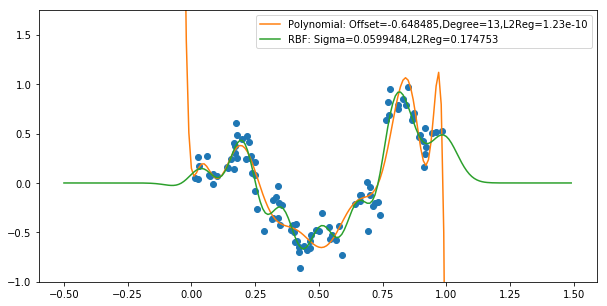

In [66]:
## Plot the best polynomial and RBF fits you found
plt.figure(figsize=(10,5))
plot_step = .01
xpts = np.arange(-.5 , 1.5, plot_step).reshape(-1,1)
plt.plot(x_train,y_train,'o')
#Plot best polynomial fit
offset= -0.648485
degree = 13
l2reg = 1.23E-10
k = functools.partial(polynomial_kernel, offset=offset, degree=degree)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "Polynomial: Offset="+str(offset)+",Degree="+str(degree)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
#Plot best RBF fit
sigma = 0.0599484
l2reg= 0.174753
k = functools.partial(RBF_kernel, sigma=sigma)
f = train_kernel_ridge_regression(x_train, y_train, k, l2reg=l2reg)
label = "RBF: Sigma="+str(sigma)+",L2Reg="+str(l2reg)
plt.plot(xpts, f.predict(xpts), label=label)
plt.legend(loc = 'best')
plt.ylim(-1,1.75)

plt.show()

#### It seems that RBF fits better than Polynomial especially for the little peak around 0.5 and the peak around 0.3. Also, RBF has a smaller test error.